# Assignment 2

In [76]:
from math import pi
import jax.numpy as jnp
from itertools import product
from matplotlib import pyplot as plt
from scipy.stats import norm
from jax.scipy.special import logsumexp
import numpy as np
from jax import grad
from PIL import Image

##  2. Implementing the Model

In [9]:
def log1pexp(x):
    """
    x: ndarray with shape (d1, d2, ..., dk)
    
    returns log1pexp of x (elementwise)
    """
    zeros = jnp.zeros_like(x)
    z = jnp.concatenate((x[..., jnp.newaxis], zeros[..., jnp.newaxis]), axis=-1)
    
    return logsumexp(z, axis=-1)

In [10]:
def log_prior(zs):
    return -0.5 * jnp.sum(jnp.log(2 * pi) + zs ** 2, axis=1, keepdims=True)


def logp_i_beats_j(zi, zj):
    return -log1pexp(jnp.array(zj - zi)).item()


def all_games_log_likelihood(zs, games):
    """
    zs: ndarray with shape (K, N)
    games: ndarray with shape (M, 2)
    """
    zs_a = zs[:, games[:, 0]]  # shape: (K, M)
    zs_b = zs[:, games[:, 1]]  # shape: (K, M)

    likelihoods = jnp.sum(-log1pexp(zs_b - zs_a), axis=1, keepdims=True)  # shape: (K, 1)
    
    return likelihoods


def joint_log_density(zs, games):
    return log_prior(zs) + all_games_log_likelihood(zs, games)


## 2. Visualize the Model on Toy Data

### 2.1. Toy Data

In [15]:
def two_player_toy_games(p1_wins, p2_wins):
    return jnp.vstack((jnp.array([[0, 1]]).repeat(p1_wins, axis=0), 
                       jnp.array([[1, 0]]).repeat(p2_wins, axis=0)))

In [16]:
two_player_toy_games(5, 3)

DeviceArray([[0, 1],
             [0, 1],
             [0, 1],
             [0, 1],
             [0, 1],
             [1, 0],
             [1, 0],
             [1, 0]], dtype=int32)

### 2.2. 2D Posterior Visualization

In [59]:
def skill_countour(f, colour=None):
    n = 100
    x = jnp.linspace(-3, 3, num=n).tolist()
    y = jnp.linspace(-3, 3, num=n).tolist()
    z_grid = jnp.array(list(product(x, y)))  # shape: (n**2, 2)
    z = f(z_grid)  # shape: (n**2, 1)
    z = z[:,0]  # shape: (n**2,)
    max_z = max(z)
    levels = [level * max_z for level in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]]
    
    if colour is None:
        p1 = plt.contour(x, y, z.reshape(n, n).T, levels=levels)
    else:
        p1 = plt.contour(x, y, z.reshape(n, n).T, colors=colour, levels=levels)

In [57]:
def plot_line_equal_skill():
    plt.plot(jnp.linspace(-3, 3, num=200), jnp.linspace(-3, 3, num=200), label='Equal skill')

1. Isocontours of the prior distribution over players' skills:

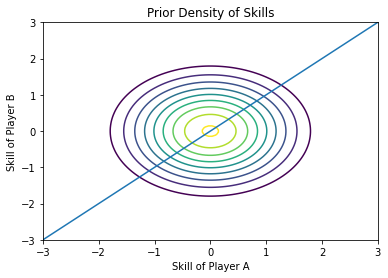

In [24]:
f = lambda zs: jnp.exp(log_prior(zs))
plot_line_equal_skill()
plt.title('Prior Density of Skills')
plt.xlabel('Skill of Player A')
plt.ylabel('Skill of Player B')
skill_countour(f)

2. Isocontours of the likelihood function:

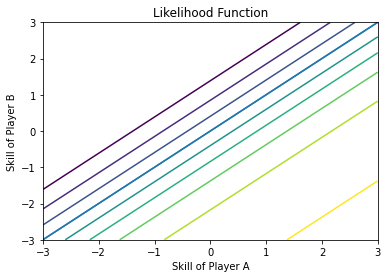

In [25]:
f = lambda zs: jnp.exp(jnp.array([[logp_i_beats_j(el[0], el[1])] for el in zs]))
plot_line_equal_skill()
plt.title('Likelihood Function')
plt.xlabel('Skill of Player A')
plt.ylabel('Skill of Player B')
skill_countour(f)

3. Isocontours of the posterior over players' skills given the observaton: player A beat player B
in 1 game.

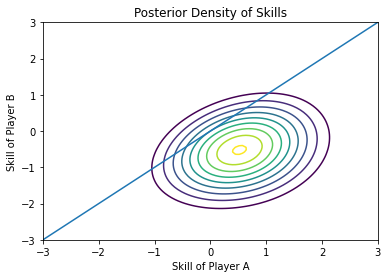

In [26]:
def f(zs):
    games = two_player_toy_games(1,0)
    return jnp.exp(all_games_log_likelihood(zs, games) + joint_log_density(zs, games)) 
plot_line_equal_skill()
plt.title('Posterior Density of Skills')
plt.xlabel('Skill of Player A')
plt.ylabel('Skill of Player B')
skill_countour(f)

4. Isocontours of the posterior over players' skills given the observation: player A beat player B
in 10 games .

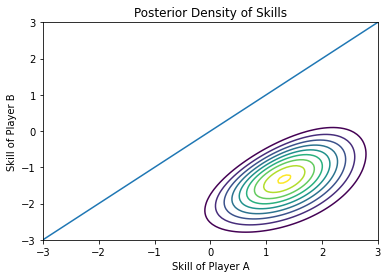

In [27]:
def f(zs):
    games = two_player_toy_games(10,0)
    return jnp.exp(all_games_log_likelihood(zs, games) + joint_log_density(zs, games)) 
plot_line_equal_skill()
plt.title('Posterior Density of Skills')
plt.xlabel('Skill of Player A')
plt.ylabel('Skill of Player B')
skill_countour(f)

5. Isocontours of the posterior over players' skills given the observation: 20 games were played,
player A beat player B in 10 games .

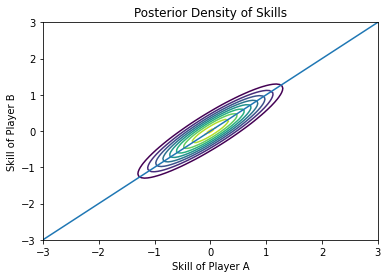

In [28]:
def f(zs):
    games = two_player_toy_games(10,10)
    return jnp.exp(all_games_log_likelihood(zs, games) + joint_log_density(zs, games)) 
plot_line_equal_skill()
plt.title('Posterior Density of Skills')
plt.xlabel('Skill of Player A')
plt.ylabel('Skill of Player B')
skill_countour(f)

## 4. Stochastic Variational Inference with Automatic Differentiation

In [61]:
def elbo(params, logp, num_samples):
    mu, ls = params['mu'], params['ls']  # mu & sigma are arrays with shepe (N,)
    epsilon = jnp.array(np.random.randn(num_samples, mu.shape[0]))  # shape: (B, N)
    samples = epsilon * ls + mu  # shape: (B, N)
    logp_estimate = logp(samples)  # shape: (B, 1)
    logq_estimate = jnp.sum(-0.5 * (jnp.log(2 * pi) + epsilon ** 2), axis=1)  # shape: (B, 1)

    return jnp.mean(logp_estimate - logq_estimate)

In [62]:
def neg_elbo(params, games=two_player_toy_games(1, 0), num_samples=100):
    def logp(zs):
        return joint_log_density(zs, games)
    
    return -elbo(params, logp, num_samples)

In [63]:
def learn_and_vis_toy_variational_approx(init_params, toy_evidence, num_iters=200, lr=1e-2, num_q_samples=10, 
                                         print_every=10):
    grad_fn = grad(neg_elbo, argnums=0)
    params_cur = init_params
    
    for i in range(num_iters):
        grad_params = grad_fn(params_cur, toy_evidence, num_q_samples)
        neg_elbo_cur = neg_elbo(params_cur, toy_evidence, num_q_samples)
        if i % print_every == 0:
            print(f'Iteration {i}, Loss: {neg_elbo_cur}')
#             print(params_cur['mu'], params_cur['ls'])
            
        for p in params_cur:
            params_cur[p] -= grad_params[p] * lr
    
    def f_true_posterior(zs):
        return jnp.exp(all_games_log_likelihood(zs, toy_evidence) + joint_log_density(zs, toy_evidence))
    
    skill_countour(f_true_posterior, colour='red')
    
    def f_var(zs):
        mu, ls = params_cur['mu'], params_cur['ls']
        out = jnp.prod((1/((2*pi) ** 0.5 * ls)) * jnp.exp(-0.5 * ((zs - mu) / ls) ** 2), axis=1, keepdims=True)
        return out
        
    skill_countour(f_var, colour='blue')

In [64]:
init_params = {'mu': jnp.array([-2.,3.]), 'ls': jnp.array([0.5, 0.])}

Iteration 0, Loss: 10.867456436157227
Iteration 20, Loss: 6.49474573135376
Iteration 40, Loss: 3.692915916442871
Iteration 60, Loss: 2.0004894733428955
Iteration 80, Loss: 0.8934826850891113
Iteration 100, Loss: 0.32260528206825256
Iteration 120, Loss: -0.0008455299539491534
Iteration 140, Loss: -0.2618485987186432
Iteration 160, Loss: -0.3316996395587921
Iteration 180, Loss: -0.271999329328537


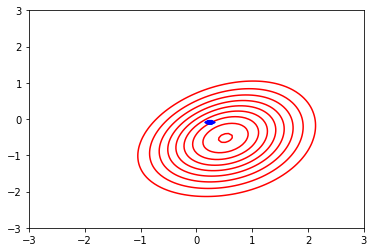

In [65]:
toy_evidence = two_player_toy_games(1, 0)

learn_and_vis_toy_variational_approx(init_params, toy_evidence, num_iters=200, lr=1e-2, num_q_samples=100,
                                    print_every=20)

Iteration 0, Loss: 57.44834899902344
Iteration 20, Loss: 16.28907585144043
Iteration 40, Loss: 3.8776960372924805
Iteration 60, Loss: 1.8055009841918945
Iteration 80, Loss: 1.5333832502365112


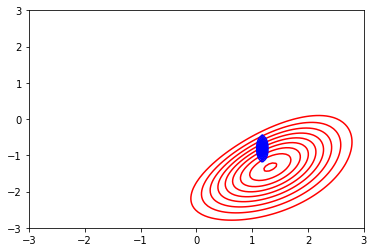

In [67]:
init_params = {'mu': jnp.array([-2.,3.]), 'ls': jnp.array([0.5, 2.3])}

toy_evidence = two_player_toy_games(10, 0)

learn_and_vis_toy_variational_approx(init_params, toy_evidence, num_iters=100, lr=1e-2, num_q_samples=100,
                                    print_every=20)

Iteration 0, Loss: 450.5347595214844
Iteration 20, Loss: 339.3358154296875
Iteration 40, Loss: 181.64584350585938
Iteration 60, Loss: 123.48141479492188
Iteration 80, Loss: 76.59013366699219
Iteration 100, Loss: 35.793453216552734
Iteration 120, Loss: 20.793067932128906
Iteration 140, Loss: 13.959464073181152
Iteration 160, Loss: 12.991683959960938
Iteration 180, Loss: 12.878211975097656


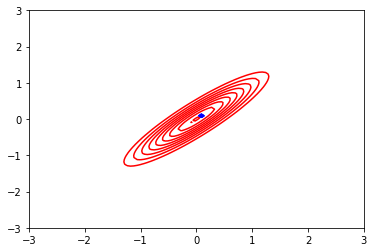

In [75]:
init_params = {'mu': jnp.array([-2.,3.]), 'ls': jnp.array([20., 11.])}

toy_evidence = two_player_toy_games(10, 10)

learn_and_vis_toy_variational_approx(init_params, toy_evidence, num_iters=200, lr=1e-2, num_q_samples=100,
                                    print_every=20)